In [1]:
import ashd, sep
import ashd.pipelinev2 as pv2
from ashd.pipelinev2.reader import Reader

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

import math, os

from astropy import visualization
from astropy.table import Table
from astropy.coordinates import SkyCoord

%matplotlib inline

sns.set()
plt.rcParams["figure.figsize"] = [12, 12]


In [2]:
r = Reader('/home/me/Code/Research/results/algo1_run3')
d = r.data

In [4]:
d['zeropt'] = [r.get_img(x).header['ZEROPT'] for x in range(len(d))]

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(24,12));
fig.suptitle("# of pixels vs flux")

z = np.polyfit(d['npix'], d['flux'], 1)
p = np.poly1d(z)

ax[0].set(xlabel="Number of pixels", ylabel="Flux")
ax[0].plot(d['npix'], d['flux'], 'o');
ax[0].plot(d['npix'], p(d['npix']), "r--");

d2 = d[d['npix'] > 20000][d['flux'] < 3e7]
ax[1].set(xlabel="Truncated npix", ylabel="Flux")
ax[1].plot(d2['npix'], d2['flux'], 'o');
ax[1].plot(d2['npix'], p(d2['npix']), "r--");


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(24,12));
fig.suptitle("Distribution plots")
ax[0].set(title="# of pixels"); ax[1].set(title="Flux")
sns.distplot(d['npix'], ax=ax[0]);
sns.distplot(d['flux'], ax=ax[1], color="red");

In [ ]:
magnitude = lambda f, m0: m0 - 2.5*math.log10(f)
mag = lambda x: magnitude(d['flux'][x] / d['npix'][x], r.get_img(x).header['ZEROPT'])

In [4]:
d['mag'] = d['zeropt'] - 2.5 * np.log10(d['flux'])
d['muavg'] = d['mag'] + 2.5 * np.log10(d['npix'] * ashd.utils.pixscale**2)

In [5]:
vavg = np.average(d['mag'], weights=d['npix'])

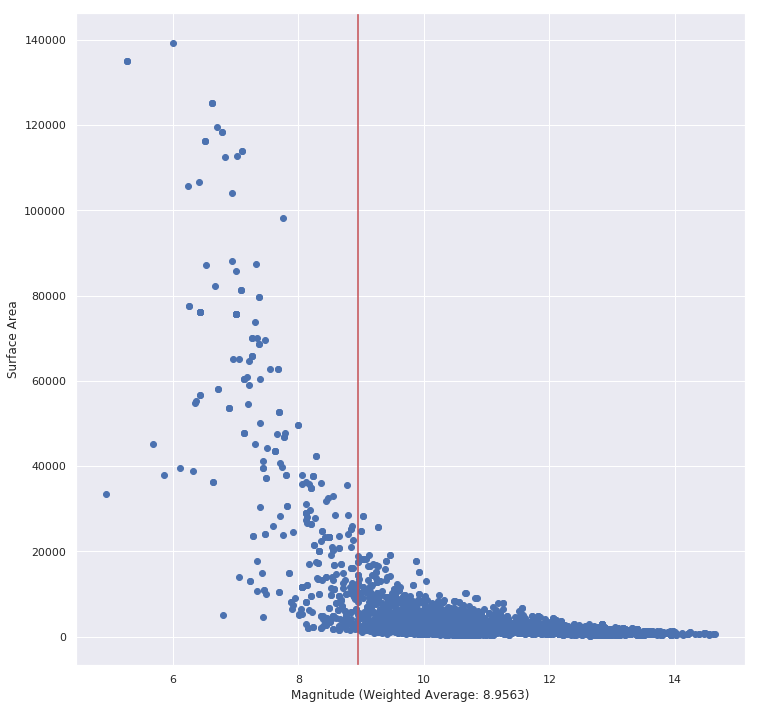

In [9]:
plt.xlabel(f"Magnitude (Weighted Average: {vavg:.4f})"); plt.ylabel("Surface Area")
plt.plot(d['mag'], d['npix'], 'o');
plt.axvline(vavg, color='r')

In [4]:
dwarfs = Table.read('../data/nearby-dwarfs.fits')
dwarfs.rename_column('_RAJ2000', 'ra')
dwarfs.rename_column('_DEJ2000', 'dec')
dwarfs = dwarfs[(~np.isnan(dwarfs['muV'])) & (~np.isnan(dwarfs['R1']))]
#dwarfs = dwarfs[(dwarfs['R1']<10) & (dwarfs['R1']>2) & (dwarfs['muV']<26.4) & (dwarfs['muV']>23)]

In [7]:
coords = SkyCoord(d['ra'], d['dec'], unit='deg')
dwarf_coords = SkyCoord(dwarfs['ra'], dwarfs['dec'], unit='deg')

idx, sep2d, _ = dwarf_coords.match_to_catalog_sky(coords)

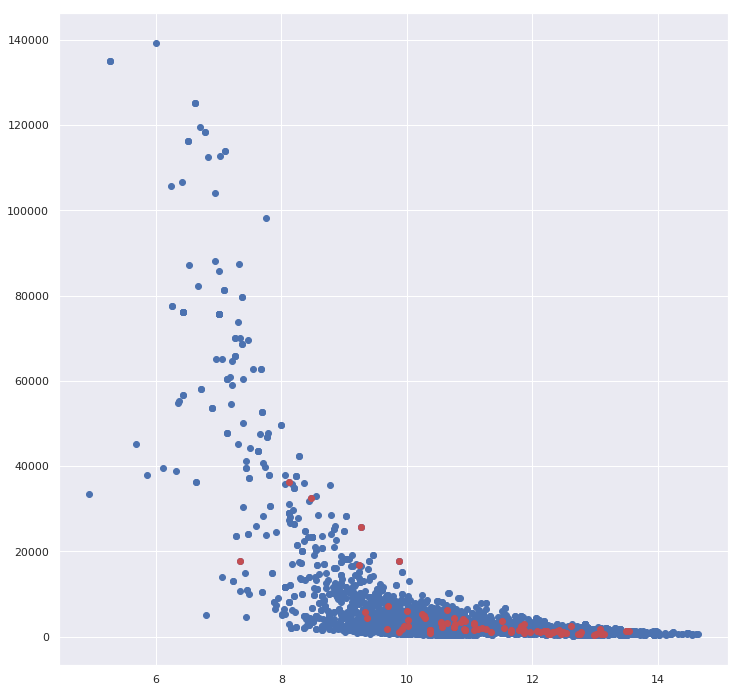

In [12]:
plt.plot(d['mag'], d['npix'], 'o');
plt.plot(d['mag'][idx], d['npix'][idx], 'o', color='r');

In [5]:
norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())

#norm2 = 

def plotme(obj, rng=[10, 99], target=None, label=None):
    vmin, vmax = np.percentile(obj, rng)
    k = target if target != None else plt
    k.imshow(obj, cmap="Greys_r", norm=norm, vmin=vmin, vmax=vmax, origin='lower')
    if label: k.set(title=label)

/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


NameError: name 'idx' is not defined

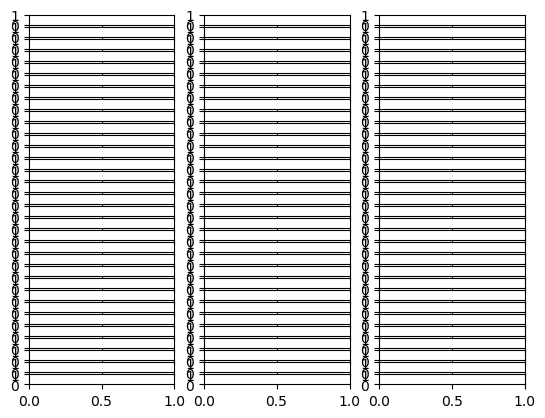

In [6]:
sns.reset_orig()
cols = 3
fig, ax = plt.subplots(ncols = cols, nrows = len(dwarfs) // cols, sharex=True)
for i in range(len(idx)):
    id_ = int(idx[i])
    #plotme(r.get_img(id_).data, target = ax[i // cols, i % cols], label=dwarfs['Name'][i])

In [11]:
b = ashd.Butler('/run/media/me/DATA/asas-sn-images')
sns.reset_orig()

/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/me/anaconda3/envs/astro/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [12]:
xlength = lambda x: d['xmax'][x] - d['xmin'][x]

def patch(idx):
    x, y, a, b, theta = [d[n][idx] for n in ('x', 'y', 'a', 'b', 'theta')]
    e = patches.Ellipse(xy=(x, y),
                width=6*a,
                height=6*b,
                angle=theta * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    
    e2 = patches.Rectangle(xy=(d['xmin'][idx], d['ymax'][idx]),
                           width=xlength(idx),
                           height=2,
                          label="Test")
    return (e, e2)

def get_frame(idx):
    return b.get_image(ra=d['ra'][idx], dec = d['dec'][idx])

def show(idx, out=None):
    fig, ax = plt.subplots();
    plotme(get_frame(idx).data, target=ax);
    for i in patch(idx): ax.add_artist(i)
    ax.text(d['xmin'][idx], d['ymax'][idx] + 5, f"{(xlength(idx) * 7.8):.2f}\"", color="orange", fontsize=20)
    ax.set_xlim(d['xmin'][idx] - 20, d['xmax'][idx] + 20)
    ax.set_ylim(d['ymin'][idx] - 20, d['ymax'][idx] + 20)
    ax.set(xlabel=', '.join([f"{d[x][idx]:.2f}" for x in ('ra', 'dec')]))
    #plt.savefig(out if out else f"scanlations/{idx}.png");

In [6]:
import ipyparallel

In [10]:
d[0:1].to_dict('list')['thresh'][0]

1.5182865858078003

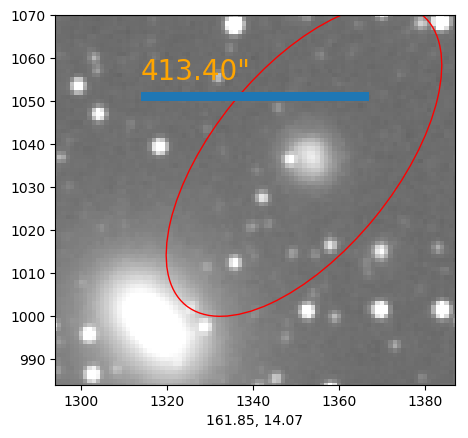

In [13]:
show(56)

In [14]:
d.loc[56, ["ra", "dec"]]

ra     161.846141
dec     14.068712
Name: 56, dtype: float64